In [ ]:
!nvidia-smi

# PyKomoran 형태소분석기 설치

In [ ]:
!pip install PyKomoran

# 실습 자료 다운로드

In [ ]:
!git clone https://github.com/bg-choi/NER.git

# 디바이스 확인

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
print("DEVICE: {} || # GPU: {}".format(device, n_gpu))

# 시드 세팅

In [ ]:
import random
import numpy as np

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if n_gpu > 0:
    torch.cuda.manual_seed_all(seed)

# 데이터 로딩

## 데이터 로딩 함수 정의

In [ ]:
import os
import json

def load_json(file_dir, file_name):
    with open(os.path.join(file_dir, file_name), 'r') as fin:
        return json.load(fin)

## 데이터 로딩

In [ ]:
train_raw = load_json('./NER/', 'train.json')
valid_raw = load_json('./NER/', 'valid.json')
test_raw = load_json('./NER/', 'test.json')

print("The number of train data: {}".format(len(train_raw)))
print("The number of dev data: {}".format(len(valid_raw)))
print("The number of test data: {}".format(len(test_raw)))

# 데이터 타입 및 구조 확인

In [ ]:
"""
로딩한 데이터의 타입과 구조를 확인하시오.
"""


# PyKomoran을 이용한 형태소 분석

In [ ]:
from PyKomoran import Komoran

pos_tagger = Komoran('EXP')
pos_tagged_text = pos_tagger.get_list(train_raw[1]['text'])
for token in pos_tagged_text:
    morpheme, pos = str(token).split("/")
    print("{}/\t{}".format(morpheme, pos))

# 실습 - 문장을 입력하고 komoran 함수를 사용해 형태소 분석 해보기

In [ ]:
""" [실습] 원하는 문장을 Komoran을 이용해 형태소 분석하고 출력 해보세요 """
text = ""

# 데이터 정형화 함수 정의

In [ ]:
def formalize_inputs(dataset):
    x_inputs = list()
    y_inputs = list()

    """
    하나의 컨텍스트를 토큰화된 단위로 리스트에 저장한 후,
    모든 컨텍스트를 x_inputs에 저장하시오.

    각 토큰에 상응하는 label을 리스트에 저장한 후,
    모든 컨텍스트에 대한 label들을 y_inputs에 저장하시오.
    """

    return x_inputs, y_inputs

# 데이터 정형화

In [ ]:
x_train, y_train = formalize_inputs(train_raw)
x_valid, y_valid = formalize_inputs(valid_raw)

for x, y in zip(x_train[1], y_train[1]):
    print("{} : {}".format(x, y))

# 단어 집합, 단어 인덱서, 레이블 집합 구축

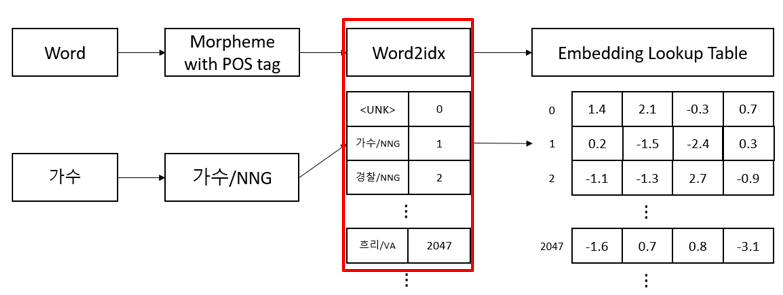

In [ ]:
token_set = set()
token2idx = dict()
label_set = set()
n_tokens = 0
n_labels = 0
max_seq_length = 0

"""
단어 집합 (token_set), token2idx, 레이블 집합(label_set), 최장 시퀀스 길이(max_seq_length)를 구축하시오.
"""


print("The number of tokens: {}".format(n_tokens))
print("The number of labels: {}".format(n_labels))
print("Max sequence length: {}".format(max_seq_length))

# token들을 index로 변환하는 함수

In [ ]:
def convert_token_to_idx(data, token2idx, max_seq_length):
    return_data = list()
    for d in data:
        temp = list()
        for token in d:
            if token in token2idx.keys():
                temp.append(token2idx[token])
            else:
                temp.append(token2idx['<unk>'])

        if len(temp) >= max_seq_length:
            temp = temp[:max_seq_length]
        else:
            padding = [token2idx['<pad>']] * (max_seq_length - len(temp))
            temp += padding

        return_data.append(temp)

    return return_data

# token들을 index로 변환

In [ ]:
x_train_idx = convert_token_to_idx(x_train, token2idx, max_seq_length)
x_valid_idx = convert_token_to_idx(x_valid, token2idx, max_seq_length)

for token, idx in zip(x_train[1], x_train_idx[1]):
    print("{}: {}".format(token, idx))

# Label들을 index로 변환하는 함수

In [ ]:
def convert_label_to_idx(data, label2idx, max_seq_length):
    return_data = list()
    for labels in data:
        temp = list()

        for label in labels:
            temp.append(label2idx[label])
        
        if len(temp) >= max_seq_length:
            temp = temp[:max_seq_length]
        else:
            padding = [-100] * (max_seq_length - len(temp))
            temp += padding
        
        return_data.append(temp)
    
    return return_data

# Label들을 index로 변환

In [ ]:
label2idx = dict()
idx2label = dict()
label_set = sorted(list(label_set))
for idx, label in enumerate(label_set):
    label2idx[label] = idx
    idx2label[idx] = label

for k, v in label2idx.items():
    print("{}: {}".format(k, v))

y_train_idx = convert_label_to_idx(y_train, label2idx, max_seq_length)
y_valid_idx = convert_label_to_idx(y_valid, label2idx, max_seq_length)

print()

for token, t_idx, label, l_idx in zip(x_train[1], x_train_idx[1], y_train[1], y_train_idx[1]):
    print("{}: {}\t\t//\t{}: {}".format(token, label,  t_idx, l_idx))

# 데이터들을 Tensor로 변환

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

"""
위에서 구축한 학습 데이터와 검증 데이터를 TensorDataset으로 구축하시오.
"""


# 실습 - NER을 위한 LSTM 모델 정의

## 순환 신경망 모델 구조

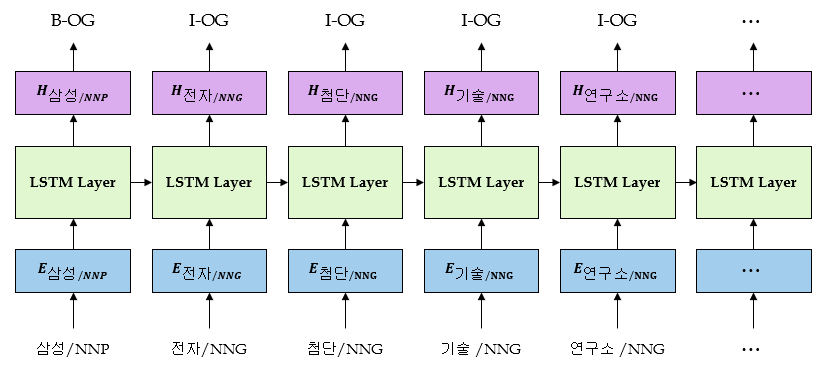

> nn.LSTM()

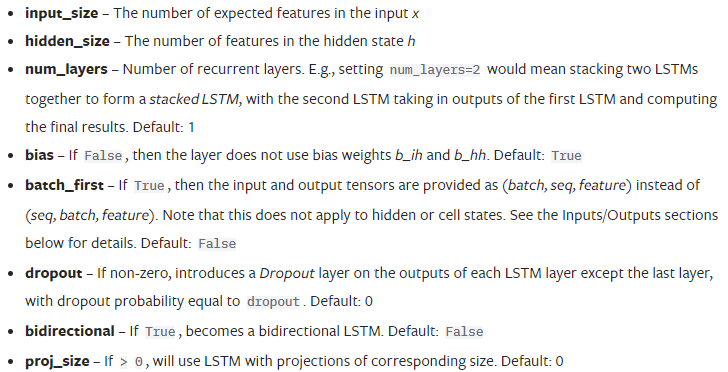

image.png

image.png

In [ ]:
import torch.nn as nn

class BasicLSTMForNER(nn.Module):
    def __init__(self, n_tokens, embedding_dim, max_seq_length, n_labels):
        super(BasicLSTMForNER, self).__init__()
        """
        nn.Embedding()
        nn.LSTM()
        nn.Linear()
        을 사용하시오.
        """
        

    def forward(self, x_train):
        out = None
        """
        forward 함수를 구축하시오.
        """

        return out

# 모델 선언

In [ ]:
embedding_dim = 64

model = BasicLSTMForNER(n_tokens, embedding_dim, max_seq_length, n_labels)
model.to(device)

# 학습

In [ ]:
from torch.optim import Adam
from tqdm import tqdm

"""
학습 프로세스를 구현하시오.
""""


# 테스트 및 성능 평가

In [ ]:
x_test, y_test = formalize_inputs(test_raw)

x_test_idx = convert_token_to_idx(x_test, token2idx, max_seq_length)
y_test_idx = convert_label_to_idx(y_test, label2idx, max_seq_length)

x_test_tensor = torch.tensor([x for x in x_test_idx], dtype=torch.long)
y_test_tensor = torch.tensor([y for y in y_test_idx], dtype=torch.long)

test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

test_batch_size = 8
test_dataloader = DataLoader(dataset=test_dataset, batch_size=test_batch_size, shuffle=True)

all_preds = list()
all_labels = list()

model.eval()
with torch.no_grad():
    for test_batch in tqdm(test_dataloader, position=0, desc="Test..."):
        test_x, test_y = tuple(b.to(device) for b in test_batch)
        test_y_preds = model(test_x)

        predicted_labels = list()
        true_labels = list()
        for pred_idx, true_idx in zip(torch.argmax(test_y_preds, dim=-1)[test_y != -100], test_y[test_y != -100]):
            predicted_labels.append(idx2label[pred_idx.item()])
            true_labels.append(idx2label[true_idx.item()])
        
        all_preds.append(predicted_labels)
        all_labels.append(true_labels)

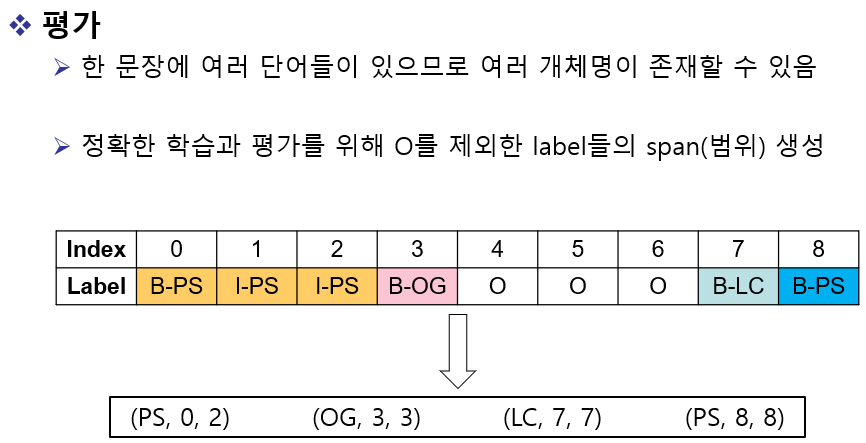

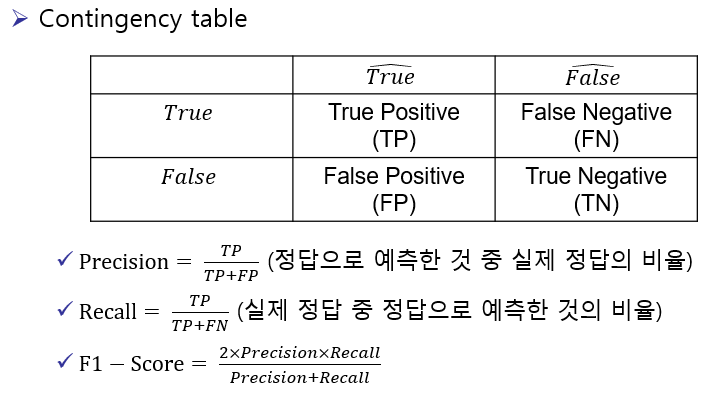

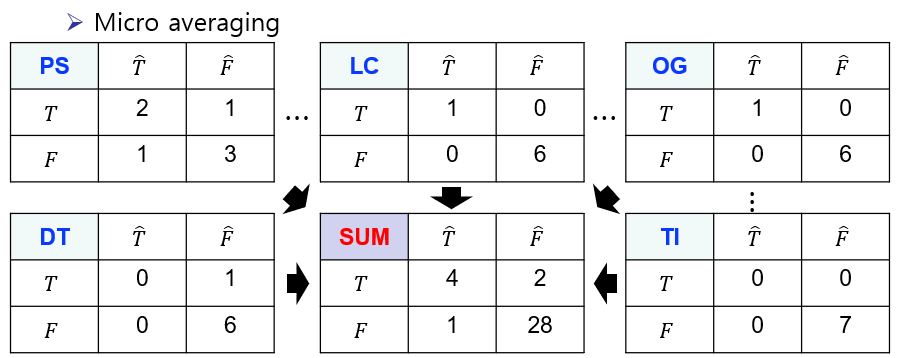

# 성능 평가 함수

In [ ]:
from collections import defaultdict

def get_entity_spans(seq):
    if any(isinstance(s, list) for s in seq):
        seq = [item for sublist in seq for item in sublist + ['O']]
    
    pre_bio = 'O'
    pre_ne_type = ''
    begin_offset = 0
    start_entity = False
    spans = list()

    for i, label in enumerate(seq + ['O']):
        cur_bio = label[0]
        cur_ne_type = label.split('-')[-1]

        if (pre_bio == 'B' and (cur_bio == 'B' or cur_bio == 'O' or (cur_bio == 'I' and cur_ne_type != pre_ne_type))) and start_entity:
            spans.append((pre_ne_type, begin_offset, i-1))
        elif (pre_bio == 'I' and (cur_bio == 'B' or cur_bio == 'O' or (cur_bio == 'I' and cur_ne_type != pre_ne_type))) and start_entity:
            spans.append((pre_ne_type, begin_offset, i-1))
        
        if cur_bio == 'B':
            begin_offset = i
            start_entity = True
        
        pre_bio = cur_bio
        pre_ne_type = cur_ne_type
    
    return spans

In [ ]:
def precision_score(y_true, y_pred):
    score = None
    """
    위의 get_entity_spans 함수를 이용해 precision score를 구하시오.
    """

    return score

def recall_score(y_true, y_pred):
    score = None
    """
    위의 get_entity_spans 함수를 이용해 precision score를 구하시오.
    """

    return score

def f1_score(p, r):
    score = 2 * p * r / (p + r) if p + r > 0 else 0

    return score

# 성능 평가

In [ ]:
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(precision, recall)

print("Precision score: {:.3f}%".format(precision))
print("Recall score: {:.3f}%".format(recall))
print("F1 score: {:.3f}%".format(f1))

# 사전학습 된 단어 임베딩을 활용한 NER

# 사전학습 된 단어 임베딩 및 단어 사전 로딩

In [ ]:
with open('./NER/glove.npy', 'rb') as fin:
    glove = np.load(fin)

glove_tensor = torch.tensor([x for x in glove], dtype=torch.float)
print("The number of pre-trained words: {}".format(len(glove_tensor)))
embedding_dim = glove_tensor.size(1)

token2idx = dict()
with open('./NER/word.dict', 'r') as fin:
    for line in fin.readlines():
        token, idx = line.replace("\n", "").split("\t")
        token2idx[token] = int(idx)
n_tokens = len(token2idx)

# 입력 텐서 구축

In [ ]:
"""
입력 텐서 구축 - 위와 동일
"""


# 모델 정의

In [ ]:
"""
모델 정의 및 선언 - 위와 동일
"""


# 학습

In [ ]:
"""
학습 프로세스 - 위와 동일
"""


# 테스트 및 성능 평가

In [ ]:
"""
테스트 및 성능 평가 - 위와 동일
"""


# 실습 과제

##RNN, CNN, MLP 등을 이용하여 본 실습에서 구축한 모델의 성능보다 좋은 성능을 보여주는 모델을 구축하시오.

##제출: bonggeun.choi818@gmail.com
##제출물: .ipynb 파일